In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix, precision_score, recall_score, log_loss
from sklearn.model_selection import GridSearchCV

In [60]:
#Used processed datasets
train_df = pd.read_csv('/content/drive/MyDrive/Fake_News_ShareTask/Task1/Preprocessing/processed_train.csv')
train_df.head()

,text,label
0,നലല അവതരണ സതയ പറതത വരടട,Fake
1,masha allah,Fake
2,അനവഷണ കഴയമപൾ യകക എതരയ കലപ ആകമ സവനത തനന പടചച അക...,Fake
3,illathentha avaru purath vidayittalland verenth,Fake
4,barana pakshathin matoru niyamamnalla moyanth ...,original


In [61]:
val_df = pd.read_csv('/content/drive/MyDrive/Fake_News_ShareTask/Task1/Preprocessing/processed_dev.csv')
val_df.head()

,text,label
0,full musilm verodamum,Fake
1,പകഷകള മഗങങള ലകതത സഖമയ ജവകകനന വവരവ വദയഭയസവ ഉണട ...,Fake
2,തടകകരൻ പതര കടടൻ പറഞഞപപ മററര ഒനന ഇലലതതവൻ പറയനന,original
3,കഭളമമറനന,original
4,തരവതര അലല കറണയ കകടട കലലകയണ,original


In [62]:
test_df= pd.read_csv('/content/drive/MyDrive/Fake_News_ShareTask/Task1/Preprocessing/processed_test.csv')
test_df.head()

,Id,text
0,Fake_01,ഉളള ലഗഡവൻ ഇപപള എനത കരണ
1,Fake_02,രജനഷ പറഞഞപല എനകകപപൾ തനനയത അങങനയണ ഇപപൾ തനനനനത ഇ...
2,Fake_03,ചടട വർതത വയകകനനത കരളതതലണ ഭരകകനന നർതത ഇനതയയലലലഇ...
3,Fake_04,shame for entir woman kerala
4,Fake_05,code janagh andhu wide busi cheythalum vijayik...


In [63]:
# Combine train and validation data
X_train = pd.concat([train_df['text'], val_df['text']]).fillna('')
y_train = pd.concat([train_df['label'], val_df['label']]).reset_index(drop=True)

In [64]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(test_df['text'].fillna(''))

In [78]:
# Function to evaluate model performance
def evaluate_model(model, X, y, dataset_name="Dataset"):
    predictions = model.predict(X)
    probabilities = model.predict_proba(X) if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, average='macro')
    rec = recall_score(y, predictions, average='macro')
    f1 = f1_score(y, predictions, average='macro')
    loss = log_loss(y, probabilities) if probabilities is not None else None
    conf_matrix = confusion_matrix(y, predictions)
    print(f"\n{dataset_name} Evaluation:")
    print(f"Accuracy: {acc:.4f}")
    if loss is not None:
        print(f"Log Loss: {loss:.4f}")
    print(f"Precision (Macro): {prec:.4f}")
    print(f"Recall (Macro): {rec:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y, predictions))

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Original', 'Fake'],
        yticklabels=['Original', 'Fake']
    )
    plt.title(f"Confusion Matrix for {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, loss, prec, rec, f1

In [79]:
# Logistic Regression with Hyperparameter Tuning

lr_param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000), lr_param_grid, cv=5, scoring='f1_macro')
lr_grid.fit(X_train_vectorized, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
             scoring='f1_macro')

In [80]:
lr_best = lr_grid.best_estimator_


Evaluating Logistic Regression on Training Data...

Training Evaluation:
Accuracy: 0.9251
Log Loss: 0.3916
Precision (Macro): 0.9276
Recall (Macro): 0.9245
F1-Score (Macro): 0.9249
Classification Report:
              precision    recall  f1-score   support

        Fake       0.96      0.89      0.92      2005
    original       0.90      0.96      0.93      2067

    accuracy                           0.93      4072
   macro avg       0.93      0.92      0.92      4072
weighted avg       0.93      0.93      0.92      4072



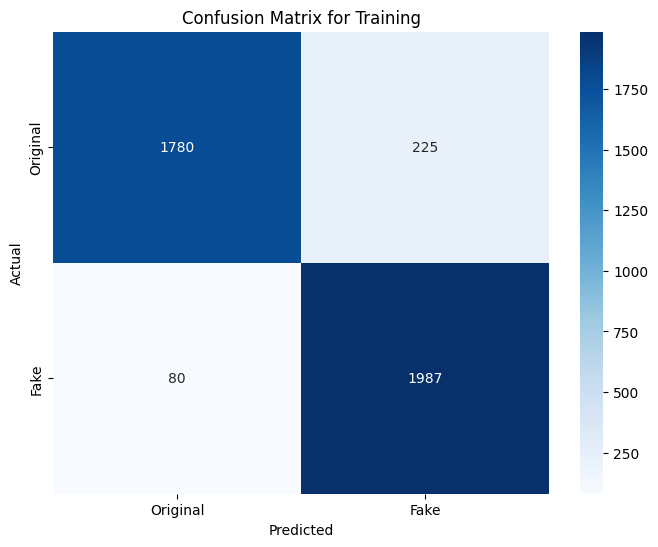

In [81]:
print("\nEvaluating Logistic Regression on Training Data...")
evaluate_model(lr_best, X_train_vectorized, y_train, "Training")
test_predictions = lr_best.predict(X_test_vectorized)

In [82]:
test_df['Predicted_Label'] = test_predictions
output_csv_path = '/content/drive/MyDrive/Fake_News_ShareTask/Task1/Training_Models/Base_Models/tfidf_logistic_regression.csv'
test_df.to_csv(output_csv_path, index=False, encoding='utf-8')
print(f"\nTest predictions saved to {output_csv_path}")


Test predictions saved to /content/drive/MyDrive/Fake_News_ShareTask/Task1/Training_Models/Base_Models/tfidf_logistic_regression.csv


In [95]:
# Multinomial Naive Bayes with Hyperparameter Tuning

from sklearn.naive_bayes import MultinomialNB
mnb_param_grid = {'alpha': [0.1, 0.5, 1.0]}
mnb_grid = GridSearchCV(MultinomialNB(), mnb_param_grid, cv=5, scoring='f1_macro')
mnb_grid.fit(X_train_vectorized, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0]}, scoring='f1_macro')


Evaluating Multinomial Naive Bayes on Training Data...

Training Evaluation:
Accuracy: 0.9199
Log Loss: 0.3193
Precision (Macro): 0.9205
Recall (Macro): 0.9197
F1-Score (Macro): 0.9199
Classification Report:
              precision    recall  f1-score   support

        Fake       0.93      0.90      0.92      2005
    original       0.91      0.94      0.92      2067

    accuracy                           0.92      4072
   macro avg       0.92      0.92      0.92      4072
weighted avg       0.92      0.92      0.92      4072



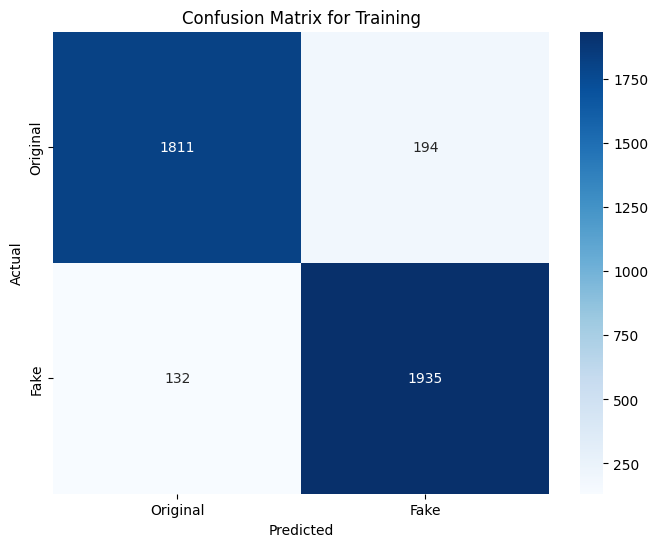

In [96]:
mnb_best = mnb_grid.best_estimator_

print("\nEvaluating Multinomial Naive Bayes on Training Data...")
evaluate_model(mnb_best, X_train_vectorized, y_train, "Training")

test_predictions = mnb_best.predict(X_test_vectorized)

In [97]:
test_df['Predicted_Label'] = test_predictions
output_csv_path = '/content/drive/MyDrive/Fake_News_ShareTask/Task1/Training_Models/Base_Models/tfidf_MultinomialNB.csv'
test_df.to_csv(output_csv_path, index=False, encoding='utf-8')
print(f"\nTest predictions saved to {output_csv_path}")


Test predictions saved to /content/drive/MyDrive/Fake_News_ShareTask/Task1/Training_Models/Base_Models/tfidf_MultinomialNB.csv


In [91]:
#Random Forest with Hyperparameter tuning

from sklearn.ensemble import RandomForestClassifier
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
rf_grid.fit(X_train_vectorized, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='f1_macro')


Evaluating Random Forest Classifier on Training Data...

Training Evaluation:
Accuracy: 0.9617
Log Loss: 0.1861
Precision (Macro): 0.9625
Recall (Macro): 0.9614
F1-Score (Macro): 0.9616
Classification Report:
              precision    recall  f1-score   support

        Fake       0.98      0.94      0.96      2005
    original       0.95      0.98      0.96      2067

    accuracy                           0.96      4072
   macro avg       0.96      0.96      0.96      4072
weighted avg       0.96      0.96      0.96      4072



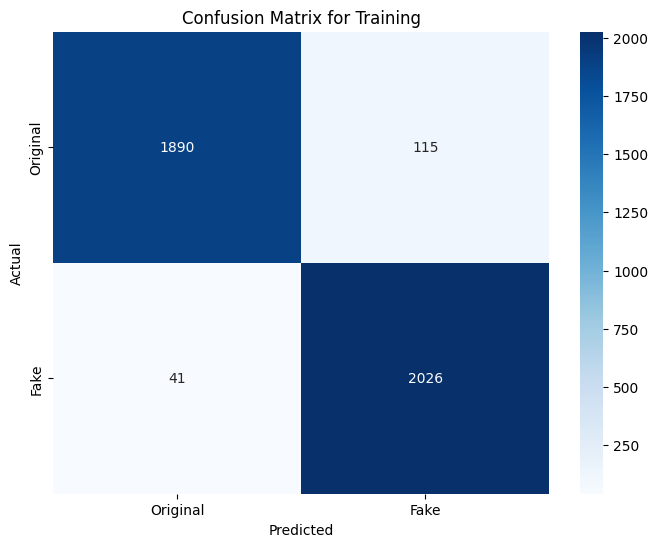

In [98]:
rf_best = rf_grid.best_estimator_

print("\nEvaluating Random Forest Classifier on Training Data...")
evaluate_model(rf_best, X_train_vectorized, y_train, "Training")

test_predictions = rf_best.predict(X_test_vectorized)

In [99]:
test_df['Predicted_Label'] = test_predictions
output_csv_path = '/content/drive/MyDrive/Fake_News_ShareTask/Task1/Training_Models/Base_Models/tfidf_RandomForest.csv'
test_df.to_csv(output_csv_path, index=False, encoding='utf-8')
print(f"\nTest predictions saved to {output_csv_path}")


Test predictions saved to /content/drive/MyDrive/Fake_News_ShareTask/Task1/Training_Models/Base_Models/tfidf_RandomForest.csv


In [100]:
#SVM with Hyperparameter Tuning

from sklearn.svm import SVC
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid = GridSearchCV(SVC(probability=True), svm_param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
svm_grid.fit(X_train_vectorized, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='f1_macro')


Evaluating SVM Classifier on Training Data...

Training Evaluation:
Accuracy: 0.9656
Log Loss: 0.1547
Precision (Macro): 0.9670
Recall (Macro): 0.9652
F1-Score (Macro): 0.9656
Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.94      0.96      2005
    original       0.95      0.99      0.97      2067

    accuracy                           0.97      4072
   macro avg       0.97      0.97      0.97      4072
weighted avg       0.97      0.97      0.97      4072



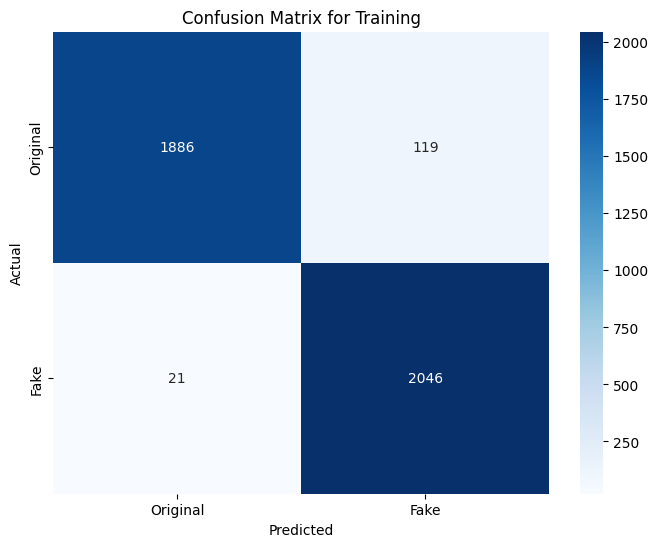

In [101]:
svm_best = svm_grid.best_estimator_

print("\nEvaluating SVM Classifier on Training Data...")
evaluate_model(svm_best, X_train_vectorized, y_train, "Training")

test_predictions = svm_best.predict(X_test_vectorized)

In [102]:
test_df['Predicted_Label'] = test_predictions
output_csv_path = '/content/drive/MyDrive/Fake_News_ShareTask/Task1/Training_Models/Base_Models/tfidf_SVM.csv'
test_df.to_csv(output_csv_path, index=False, encoding='utf-8')
print(f"\nTest predictions saved to {output_csv_path}")


Test predictions saved to /content/drive/MyDrive/Fake_News_ShareTask/Task1/Training_Models/Base_Models/tfidf_SVM.csv
